In [ ]:
# ! pip install langchain unstructured[all-docs] pydantic lxml

## Data Loading

### Partition PDF tables, text, and images
  
* `LLaVA` Paper: https://arxiv.org/pdf/2304.08485.pdf
* Use [Unstructured](https://unstructured-io.github.io/unstructured/) to partition elements

In [2]:
from typing import Any

from pydantic import BaseModel
from unstructured.partition.pdf import partition_pdf

# Path to save images
path = "C:\\Users\\Barani\\Desktop\\chatbot\\"

# Get elements
raw_pdf_elements = partition_pdf(
    filename=path + "llava.pdf",
    # Using pdf format to find embedded image blocks
    extract_images_in_pdf=True,
    # Use layout model (YOLOX) to get bounding boxes (for tables) and find titles
    # Titles are any sub-section of the document
    infer_table_structure=True,
    # Post processing to aggregate text once we have the title
    chunking_strategy="by_title",
    # Chunking params to aggregate text blocks
    # Attempt to create a new chunk 3800 chars
    # Attempt to keep chunks > 2000 chars
    # Hard max on chunks
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=path,
)

This function will be deprecated in a future release and `unstructured` will simply use the DEFAULT_MODEL from `unstructured_inference.model.base` to set default model name


In [3]:
# Create a dictionary to store counts of each type
category_counts = {}

for element in raw_pdf_elements:
    category = str(type(element))
    if category in category_counts:
        category_counts[category] += 1
    else:
        category_counts[category] = 1

# Unique_categories will have unique elements
# TableChunk if Table > max chars set above
unique_categories = set(category_counts.keys())
category_counts

{"<class 'unstructured.documents.elements.CompositeElement'>": 31,
 "<class 'unstructured.documents.elements.Table'>": 4}

In [4]:
class Element(BaseModel):
    type: str
    text: Any


# Categorize by type
categorized_elements = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        categorized_elements.append(Element(type="table", text=str(element)))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        categorized_elements.append(Element(type="text", text=str(element)))

# Tables
table_elements = [e for e in categorized_elements if e.type == "table"]
print(len(table_elements))

# Text
text_elements = [e for e in categorized_elements if e.type == "text"]
print(len(text_elements))

4
31


## Multi-vector retriever

Use [multi-vector-retriever](/docs/modules/data_connection/retrievers/multi_vector#summary).

Summaries are used to retrieve raw tables and / or raw chunks of text.

### Text and Table summaries

Here, we use Ollama to run LLaMA2 locally. 

See details on installation [here](/docs/guides/development/local_llms).

In [5]:
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

In [6]:
# Prompt
prompt_text = """You are an assistant tasked with summarizing tables and text. \
Give a concise summary of the table or text. Table or text chunk: {element} """
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatOllama(model="mistral",temperature=0)
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [7]:
# Apply to text
texts = [i.text for i in text_elements if i.text != ""]
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})

In [8]:
# Apply to tables
tables = [i.text for i in table_elements]
table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

In [9]:
text_summaries[0]

' This table and text describe a study conducted by Haotian Liu, Chunyuan Li, Qingyang Wu, and Yong Jae Lee, where they introduce LLaVA (Large Language and Vision Assistant), an end-to-end trained large multimodal model that connects a vision encoder and a language model for general-purpose visual and language understanding. They used GPT-4 to generate multimodal instruction-following data, which was then used for instruction tuning. The experiments showed that LLaVA demonstrated impressive multimodal chat abilities and yielded a 85.1% relative score compared with GPT-4 on a synthetic multimodal instruction-following dataset. When fine-tuned on Science QA, the synergy of LLaVA and GPT-4 achieved a new state-of-the-art accuracy of 92.53%. The researchers constructed two evaluation benchmarks for future research on visual instruction following and made their data, model, and code publicly available.'

In [10]:
table_summaries[0]

' This table summarizes the performance of a conversational model in handling different levels of conversation complexity and detail. The first column represents the conversation type, with "Detail description" indicating a conversation with full data and detailed descriptions, "Complex Conv" representing complex conversations, and "No Instruction Tuning" denoting conversations without specific instructions. The following columns display the model\'s performance in terms of accuracy percentage for each conversation type.\n\nThe results show that the conversational model performs best when handling detailed descriptions with no instruction tuning (96.5%), but its accuracy decreases significantly as complexity increases, particularly for complex conversations with full data (18.5%). The overall trend indicates a decline in performance as both detail and complexity levels rise.'

### Images

We will implement `Option 2` discussed above: 

* Use a multimodal LLM ([LLaVA](https://llava.hliu.cc/)) to produce text summaries from images
* Embed and retrieve text 
* Pass text chunks to an LLM for answer synthesis 

#### Image summaries 

We will use [LLaVA](https://github.com/haotian-liu/LLaVA/), an open source multimodal model.
 
We will use [llama.cpp](https://github.com/ggerganov/llama.cpp/pull/3436) to run LLaVA locally (e.g., on a Mac laptop):

* Clone [llama.cpp](https://github.com/ggerganov/llama.cpp)
* Download the LLaVA model: `mmproj-model-f16.gguf` and one of `ggml-model-[f16|q5_k|q4_k].gguf` from [LLaVA 7b repo](https://huggingface.co/mys/ggml_llava-v1.5-7b/tree/main)
* Build
```
mkdir build && cd build && cmake ..
cmake --build .
```
* Run inference across images:
```
/Users/rlm/Desktop/Code/llama.cpp/bin/llava -m ../models/llava-7b/ggml-model-q5_k.gguf --mmproj ../models/llava-7b/mmproj-model-f16.gguf --temp 0.1 -p "Describe the image in detail. Be specific about graphs, such as bar plots." --image "$img" > "$output_file"
```

In [11]:
# %%bash

# # Define the directory containing the images
# IMG_DIR=~/Desktop/Papers/LLaVA/

# # Loop through each image in the directory
# for img in "${IMG_DIR}"*.jpg; do
#     # Extract the base name of the image without extension
#     base_name=$(basename "$img" .jpg)

#     # Define the output file name based on the image name
#     output_file="${IMG_DIR}${base_name}.txt"

#     # Execute the command and save the output to the defined output file
#     /Users/rlm/Desktop/Code/llama.cpp/bin/llava -m ../models/llava-7b/ggml-model-q5_k.gguf --mmproj ../models/llava-7b/mmproj-model-f16.gguf --temp 0.1 -p "Describe the image in detail. Be specific about graphs, such as bar plots." --image "$img" > "$output_file"

# done
# # %%bash

# # # Define the directory containing the images
# # IMG_DIR=~/Desktop/Papers/LLaVA/

# # # Loop through each image in the directory
# # for img in "${IMG_DIR}"*.jpg; do
# #     # Extract the base name of the image without extension
# #     base_name=$(basename "$img" .jpg)

# #     # Define the output file name based on the image name
# #     output_file="${IMG_DIR}${base_name}.txt"

# #     # Execute the command and save the output to the defined output file
# #     # /Users/rlm/Desktop/Code/llama.cpp/bin/llava -m ../models/llava-7b/ggml-model-q5_k.gguf --mmproj ../models/llava-7b/mmproj-model-f16.gguf --temp 0.1 -p "Describe the image in detail. Be specific about graphs, such as bar plots." --image "$img" > "$output_file"
# #     C:\\Users\\Barani\\Desktop\\chatbot\\llama.cpp\\examples\\llava -m ..C:\\Users\\Barani\\Desktop\\chatbot\\ggml-model-q4_k.gguf --mmproj ..C:\\Users\\Barani\\Desktop\\chatbot\\mmproj-model-f16.gguf --temp 0.1 -p "Describe the image in detail. Be specific about graphs, such as bar plots." --image "%img%" > "%output_file%"


# # done

# # # Define the directory containing the images
# # IMG_DIR = "C:\Users\YourUsername\Desktop\Papers\LLaVA\"

# # # Get all the .jpg files in the directory
# # images = Get-ChildItem -Path IMG_DIR -Filter *.jpg

# # # Loop through each image in the directory
# # foreach ($img in $images) {
# #     # Extract the base name of the image without extension
# #     base_name = [IO.Path]::GetFileNameWithoutExtension($img.Name)

# #     # Define the output file name based on the image name
# #     output_file = "${IMG_DIR}${base_name}.txt"

# #     # Execute the command and save the output to the defined output file
# #     & "C:\Users\YourUsername\Desktop\Code\llama.cpp\bin\llava.exe" -m "..\models\llava-7b\ggml-model-q5_k.gguf" --mmproj "..\models\llava-7b\mmproj-model-f16.gguf" --temp 0.1 -p "Describe the image in detail. Be specific about graphs, such as bar plots." --image "$img.FullName" > "$output_file"
# # }
# # import os
# # import subprocess

# # # Define the directory containing the images
# # IMG_DIR = "C:\\Users\\Barani\\Desktop\\chatbot\\figures"

# # # Get all the .jpg files in the directory
# # images = [f for f in os.listdir(IMG_DIR) if f.endswith('.jpg')]

# # # Loop through each image in the directory
# # for img in images:
# #     # Extract the base name of the image without extension
# #     base_name = os.path.splitext(img)[0]

# #     # Define the output file name based on the image name
# #     output_file = os.path.join(IMG_DIR, f"{base_name}.txt")

# #     # Define the command
# #     command = f"C:/Users/YourUsername/Desktop/Code/llama.cpp/bin/llava.exe -m ../models/llava-7b/ggml-model-q5_k.gguf --mmproj ../models/llava-7b/mmproj-model-f16.gguf --temp 0.1 -p \"Describe the image in detail. Be specific about graphs, such as bar plots.\" --image {os.path.join(IMG_DIR, img)} > {output_file}"

# #     # Execute the command
# #     subprocess.run(command, shell=True)



In [13]:
import os
import ollama
from tqdm import tqdm

# Initialize an empty list to store the results
img_summaries = []

# Define the directory path
dir_path = "C:\\Users\\Barani\\Desktop\\chatbot\\figures"

# Get a list of all .jpg files in the directory
jpg_files = [f for f in os.listdir(dir_path) if f.endswith(".jpg")]

# Iterate over all .jpg files in the directory with a tqdm progress bar
for filename in tqdm(jpg_files, desc="Processing images"):
    # Construct the full file path
    file_path = os.path.join(dir_path, filename)
    
    # Call the chat function with the image file
    res = ollama.chat(
        model="llava",
        messages=[
            {
                'role':'user',
                'content':'Describe this image :',
                'images':[file_path]
            }
        ]
    )
    
    # Append the result to the image_summary list
    img_summaries.append(res['message']['content'])

# Print the image_summary list
print(img_summaries)


Processing images: 100%|██████████| 16/16 [07:32<00:00, 28.29s/it]

[' The image shows a humorous meme with a text overlay that reads, "sometimes I just look at pictures of the earth from space and marvel at how beautiful it all is." Below this text is a photo of a tray containing pieces of chicken or fish sticks, which are arranged to form the shape of a map. The arrangement resembles continents on Earth. The meme uses a visual pun by juxtaposing a thoughtful statement with an image of food that has been creatively shaped to mimic a world map from space. The text suggests a sense of wonder and appreciation for the natural world, while the image plays on this sentiment using food as a medium for art. ', ' The image shows a screenshot of a text message with a conversation between two individuals. One person has sent a message that says "My new website is live!" along with a link to the site. In response, another person replies "That looks funny" and includes a link to a meme, specifically a joke about punctuation marks.\n\nThe screenshot also includes a

In [8]:
# import glob
# import os

# # Get all .txt files in the directory
# file_paths = glob.glob(os.path.expanduser(os.path.join(path, "*.txt")))

# # Read each file and store its content in a list
# img_summaries = []
# for file_path in file_paths:
#     with open(file_path, "r") as file:
#         img_summaries.append(file.read())

# # Clean up residual logging
# cleaned_img_summary = [
#     s.split("clip_model_load: total allocated memory: 201.27 MB\n\n", 1)[1].strip()
#     for s in img_summaries
# ]

### Add to vectorstore

Use [Multi Vector Retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary) with summaries.

We use GPT4All embeddings to run locally, which are a [CPU optimized version of BERT](https://docs.gpt4all.io/gpt4all_python_embedding.html).

In [14]:
from langchain_community.vectorstores import FAISS
from langchain_community import embeddings


In [18]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_community.embeddings import GPT4AllEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document

# The vectorstore to use to index the child chunks
vectorstore = Chroma(
    collection_name="summaries", embedding_function=GPT4AllEmbeddings(),persist_directory="./chroma"
)
vectorstore.persist()

# The storage layer for the parent documents
store = InMemoryStore()  # <- Can we extend this to images
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

For `option 2` (above): 

* Store the image summary in the `docstore`, which we return to the LLM for answer generation.

In [19]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=s, metadata={id_key: table_ids[i]})
    for i, s in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

# Add images
img_ids = [str(uuid.uuid4()) for _ in img_summaries]
summary_img = [
    Document(page_content=s, metadata={id_key: img_ids[i]})
    for i, s in enumerate(img_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(
    list(zip(img_ids, img_summaries))
)  # Store the image summary as the raw document

### Sanity Check

Image:

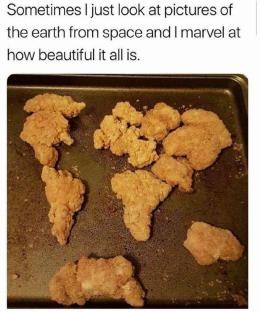

We can retrieve this image summary:

In [20]:
retriever.get_relevant_documents("Images / figures with playful and creative examples")[
    0
]

' The image shows a humorous meme with a text overlay that reads, "sometimes I just look at pictures of the earth from space and marvel at how beautiful it all is." Below this text is a photo of a tray containing pieces of chicken or fish sticks, which are arranged to form the shape of a map. The arrangement resembles continents on Earth. The meme uses a visual pun by juxtaposing a thoughtful statement with an image of food that has been creatively shaped to mimic a world map from space. The text suggests a sense of wonder and appreciation for the natural world, while the image plays on this sentiment using food as a medium for art. '

## RAG

Run [RAG pipeline](https://python.langchain.com/docs/expression_language/cookbook/retrieval).

For `option 1` (above): 

* Simply pass retrieved text chunks to LLM, as usual.

For `option 2a` (above): 

* We would pass retrieved image and images to the multi-modal LLM.
* This should be possible soon, once [llama-cpp-python add multi-modal support](https://github.com/abetlen/llama-cpp-python/issues/813).

In [29]:
vectorstore.persist()


In [33]:
from langchain_core.runnables import RunnablePassthrough

# Prompt template
template = """Answer the question based only on the following context, which can include text and tables:
{context}
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

# Option 1: LLM
model = ChatOllama(model="mistral",temperature=0)
# Option 2: Multi-modal LLM
# model = LLaVA

# RAG pipeline
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [22]:
chain.invoke(
    "What is the performance of LLaVa across across multiple image domains / subjects?"
)

" LLaVA was evaluated on a diverse set of 24 images with 60 questions in total, covering indoor and outdoor scenes, memes, paintings, sketches, etc. The results showed that LLaVA significantly outperforms BLIP-2 and OpenFlamingo in Table 5. Compared to the text-only GPT-4 model, LLaVA achieves an impressive 81.7% performance on complex reasoning questions with an overall score of 67.3%. However, it is important to note that this benchmark was designed to reveal a model's weaknesses and serve as a solid baseline for future work in developing more capable LMMs. There were also challenging examples, such as the ramen example which required multilingual understanding capability and extensive knowledge coverage, and the fridge example which required high resolution image processing and extensive knowledge coverage (Table 6). Overall, these results demonstrate the effectiveness of LLaVA for handling various image domains and its potential to inspire future work in developing more advanced LM

We can check the [trace](https://smith.langchain.com/public/ab90fb1c-5949-4fc6-a002-56a6056adc6b/r) to review retrieval.

In [22]:
chain.invoke(
    "Explain any images / figures in the paper with playful and creative examples."
)

' Sure, I\'d be happy to help! Based on the provided context, here are some playful and creative explanations for the images/figures mentioned in the paper:\n\n1. "The image features a close-up of a tray filled with various pieces of fried chicken. The chicken pieces are arranged in a way that resembles a map of the world, with some pieces placed in the shape of continents and others as countries."\n\nPlayful explanation: "Look, ma! The fried chicken is mapping out the world one piece at a time! Who needs Google Maps when you have crispy chicken wings to guide the way?"\n\nCreative explanation: "The arrangement of the fried chicken pieces creates a visual representation of the world that\'s both appetizing and adventurous. It\'s like a culinary globe-trotting experience!"\n\n2. "The image is a screenshot of a conversation between two people, likely discussing a painting."\n\nPlayful explanation: "The painting is getting a double take - these two people are having a chat about it and we

In [24]:
chain.invoke(
    "Explain any images / figures in the paper with playful and creative examples."
)

' Image 1: The first image is a meme that uses a visual pun to combine two seemingly unrelated things: looking at beautiful pictures of the Earth from space and eating chicken nuggets. In this meme, the text says "Sometimes I just look at pictures of the earth from space and marvel at how beautiful it all is." Below this text is an image of a tray with chicken or fish sticks arranged to resemble a world map. This playful and creative example uses food as a medium for art, creating a humorous representation of the Earth. The overall impression given by this meme is one of wonder and appreciation for both the natural world and the simple pleasure of eating tasty food.\n\nImage 2: In the second image, we see a screenshot of a messaging application with two individuals engaged in a conversation. One user, named "Law," sends a message containing a photo of Leonardo da Vinci\'s famous painting "The Mona Lisa." The other user uses a voice assistant or AI, as indicated by the text bubble that 

In [26]:
chain.invoke(
    "provide me the metric values of gpt 3.5 like subject , context modality and grade and average"
)

' According to the context provided, the GPT-3.5 model has a human-like score of 90.23%, and it was evaluated on ScienceQA dataset with multimodal multiple choice questions. However, the text does not provide specific values for subject, context modality, or grade for GPT-3.5 in the table format you are looking for. The average performance of GPT-3.5 is 74.64% and 75.44% with and without chain-of-thought (CoT), respectively.'

In [27]:
chain.invoke(
    "provide me the visual features of before and last"
)

' To answer your question, I\'d need to know what "before" and "last" refer to specifically in this context. Based on the provided information, it seems that "before" could refer to a previous version or state, while "last" could refer to the most recent version or state. However, without more context or specific visuals, it\'s not possible to provide you with the exact visual features of "before" and "last."\n\nAdditionally, it\'s important to note that visual features can encompass a wide range of characteristics, including but not limited to: color, texture, shape, size, position, orientation, symmetry, asymmetry, and more. Depending on the specific context or domain, some visual features may be more relevant or informative than others.'

We can check the [trace](https://smith.langchain.com/public/c6d3b7d5-0f40-4905-ab8f-3a2b77c39af4/r) to review retrieval.

In [30]:
async for chunk in chain.astream("tell me about the Chicken Nugget Map"):
#     chunks.append(chunk)
    print(chunk, end="", flush=True)

 The Chicken Nugget Map meme is a humorous image that uses chicken nuggets arranged on a tray to resemble a world map. The meme begins with text expressing admiration for the beauty of Earth from space. However, instead of an actual Earth image, the main part of the meme shows a tray of cooked chicken nuggets where each piece is positioned to represent continents and islands.

The humor lies in the unexpected juxtaposition of the text praising the earth's beauty with the mundane and unrelated image of chicken nuggets. The punchline, which appears at the bottom in smaller text, reads "I mean, it’s not the real Earth, but how beautiful it is all is," adding to the comedic effect. Overall, this meme combines food and humor, creating a fun and imaginative representation of the world.

In [34]:
async for chunk in chain.astream("tell me about  CC3M dataset"):
#     chunks.append(chunk)
    print(chunk, end="", flush=True)

 The CC3M (Conceptual Captions 3M) dataset is a large-scale multimodal benchmark for evaluating the ability of models to generate captions that accurately describe images. It consists of approximately 3 million image-caption pairs, each with an associated concept label drawn from a vocabulary of around 50,000 concepts [62]. The dataset is split into training, validation, and test sets, with roughly 2.4M, 178K, and 500K image-caption pairs, respectively. The CC3M dataset is widely used for evaluating the performance of various multimodal models in understanding images and generating descriptive captions.

In [36]:
async for chunk in chain.astream("tell me about  Figure 7"):
#     chunks.append(chunk)
    print(chunk, end="", flush=True)

 The given text appears to be a summary of a research paper or article related to language models and computer vision. It discusses various models, benchmarks, and limitations in the field. Here is a brief explanation of the content:

The text starts by mentioning some recent advancements in multimodal language models (LLMs) like LLaVA, PaLM-E, and Make-a-Scene. It then introduces two benchmarks, LLaVA-Bench (COCO) and LLaVA-Bench (In-the-Wild), to evaluate the performance of these models in handling visual instructions.

LLaVA-Bench (COCO) involves randomly selecting 30 images from COCO-Val-2014 and generating three types of questions for each image, totaling 90 questions. The benchmark aims to study the model's alignment behavior and capabilities with consistent visual inputs. The text discusses improvements in the model's performance when using instruction tuning, adding detailed description and complex reasoning questions, and having all three types of data.

LLaVA-Bench (In-the-Wi

In [37]:
async for chunk in chain.astream("tell me about frequency and Unique noun-phrases (ordered by frequency in the descending order) for CC3M"):
#     chunks.append(chunk)
    print(chunk, end="", flush=True)

 To answer your question, I'd need to access the CC3M dataset and perform some data analysis. However, based on the context of the paper you provided, LLaVA is a large language model that can generate instructions and follow them in the context of visual information. It was evaluated on two benchmarks: LLaVA-Bench (COCO) and LLaVA-Bench (In-the-Wild). The first benchmark involved generating questions for 30 images from COCO-Val-2014, while the second benchmark involved a diverse set of 24 images with manually-curated descriptions and associated questions.

Regarding your question about frequency and unique noun-phrases in CC3M, I would suggest looking up the paper or dataset documentation for more information. The CC3M dataset is a large-scale multimodal dataset that contains 14 million image-text pairs scraped from ConceptNet and CommonCrawl. It was used as one of the training datasets in the LLaVA study, but it wasn't specifically mentioned in relation to your question about frequenc

CancelledError: 

In [35]:
async for chunk in chain.astream("Unique noun-phrases (ordered by frequency in the descending order)"):
#     chunks.append(chunk)
    print(chunk, end="", flush=True)

 Here are the unique noun phrases (in order of their frequency from highest to lowest) found in the given text:

1. language model
2. few-shot learning
3. visual concepts
4. instruction-finetuned language models
5. open-source chatbot
6. pathways
7. web-scale image-text pre-training
8. long-tail visual concepts
9. multimodal language model
10. embodied multimodal language model
11. scene-based text-to-image generation
12. vision-language pre-training
13. computer vision in the wild
14. reinforce data
15. model accuracy and robustness
16. dataset reinforcement
17. human priors
18. make-a-scene
19. scene-based text-to-image generation
20. text-annotation tasks
21. crowd-workers
22. text-to-image generation
23. model accuracy
24. robustness
25. dataset reinforcement
26. human priors
27. scene-based
28. text-annotation
29. text-to-image
30. image-text pre-training
31. recent advances
32. future trends
33. Foundations and Trends® in Computer Graphics and Vision
34. Computer Vision in the Wi

CancelledError: 